### Project: Customer Segmentation - RFM

#### Objectives:
The project aim to gain insights on the customer behaviour and preferences based on their transaction records.
Customer behaviour will be evaluated based on the RFM scores and then grouped them using K-means clustering algorithm based on their RFM socres. RFM scores is a common method used for analyzing customer value and segmenting customers in marketing and CRM. RFM stands for Recency, Frequency and Monetary. <br>
<br>
**Recency:** How recently the customer make a purchase? <br>
**Frequency (F):** How often the customer make purchases? <br>
**Monetary (M):** How much money the customer spend on the purchases?
<br>

**Dataset:** A real-world dataset from the retail industry - the Online Retail dataset from UCI machine learning repository.

In [1]:
# Import necessary libraries 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

In [2]:
# Load the dataset as dataframe
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00352/Online%20Retail.xlsx"
df = pd.read_excel(url)

In [3]:
# Preview the dataframe
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
# Understand the data type of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


CustomerID is in float currently which is not an appropriate datatype, we will cast it to integer later. <br>
Also, from the non-null count, we can see that there is some null values in Description and CustomerID. We will further confirm it with the isnull function.

In [5]:
# Check if there is missing values
missing_values = df.isnull().sum()
print(missing_values)

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64


The description is the item description of each transaction, which we do not need it for our analysis. Hence, we will ignore the missing values. However, customer ID is important in identify the transactions of each customer, but there is no way for us to recover this from this public dataset, so we will remove these records instead. 

In [6]:
# Remove rows with missing CustomerID
df.dropna(subset=['CustomerID'], inplace=True)

In [7]:
# Convert datatype of CustomerID from float to int
df['CustomerID'] = df['CustomerID'].astype(int)

In [8]:
# Double check the dataframe after cleaning
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    406829 non-null  object        
 1   StockCode    406829 non-null  object        
 2   Description  406829 non-null  object        
 3   Quantity     406829 non-null  int64         
 4   InvoiceDate  406829 non-null  datetime64[ns]
 5   UnitPrice    406829 non-null  float64       
 6   CustomerID   406829 non-null  int64         
 7   Country      406829 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(4)
memory usage: 27.9+ MB


In [9]:
# Use describe() function to understand the numerical features better
df.describe()

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


There's negative value in the Quantity column. We need to remove these negative value in Quantity column because it is a dirty data.

In [10]:
# Remove rows with negative quantity.
df = df[df['Quantity'] > 0]

### RFM calculation grouped by CustomerID

First, we will create a TotalAmount column that multiply Quantity adn UnitPrice which will help in the Monetary calculation.

In [11]:
# Create TotalAmount column that contains Quantity * UnitPrice
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

In [12]:
print(df)

       InvoiceNo StockCode                          Description  Quantity  \
0         536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1         536365     71053                  WHITE METAL LANTERN         6   
2         536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3         536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4         536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
...          ...       ...                                  ...       ...   
541904    581587     22613          PACK OF 20 SPACEBOY NAPKINS        12   
541905    581587     22899         CHILDREN'S APRON DOLLY GIRL          6   
541906    581587     23254        CHILDRENS CUTLERY DOLLY GIRL          4   
541907    581587     23255      CHILDRENS CUTLERY CIRCUS PARADE         4   
541908    581587     22138        BAKING SET 9 PIECE RETROSPOT          3   

               InvoiceDate  UnitPrice  CustomerID         Country  TotalAmo

**Recency calculation:** <br>
We will calculate the difference between the most recent purchase date and a reference date(snapshot_date), to gives the number of days since the customer's last purchase. The snapshot_date is a day later than the most recent date in the "IncoiceDate" column.
<br>
**Frequency calculation:**<br>
We will count the number of unique invoces of each customer.
<br>
**Monetary calculation:**<br>
We will average the TotalAmouont across transactions of each customer.

In [31]:
snapshot_date = max(df['InvoiceDate']) + pd.DateOffset(days=1)

In [34]:
rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo' : 'nunique',
    'TotalAmount' : 'sum'
})

In [38]:
# Rename the columns for readability
rfm.rename(columns={'InvoiceDate': 'Recency', 'InvoiceNo': 'Frequency', 'TotalAmount': 'MonetaryValue'}, inplace=True)
rfm.head()

,Recency,Frequency,MonetaryValue
CustomerID,,,
12346,326,1,77183.60
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


#### Map RFM values to a 1-5 score.

In [39]:
# check the values of the RFM columns
rfm.describe()

,Recency,Frequency,MonetaryValue
count,4339.000000,4339.000000,4339.000000
mean,92.518322,4.271952,2053.793018
std,100.009747,7.705493,8988.248381
min,1.000000,1.000000,0.000000
25%,18.000000,1.000000,307.245000
50%,51.000000,2.000000,674.450000
75%,142.000000,5.000000,1661.640000
max,374.000000,210.000000,280206.020000


We can use the statistic value above as a reference for the RFM score definition.

In [41]:
# Define the custom bin edges for Recency, Frequency, and Monetary scores
recency_bins = [rfm['Recency'].min()-1, 20,50,150,250,rfm['Recency'].max()]
frequency_bins = [rfm['Frequency'].min()-1, 2,3,10,100,rfm['Frequency'].max()]
monetary_bins = [rfm['MonetaryValue'].min(), 300,600,2000,5000,rfm['MonetaryValue'].max()]

Now we will map the scores (1-5) to the corresponding labels of the bins.

In [44]:
# Map Recency score based on custome bins
rfm['R_score'] = pd.cut(rfm['Recency'], bins = recency_bins, labels=range(1,6), include_lowest=True)

# Reverse the Reency scores so that higher score indicate more recent purchases
rfm['R_score'] = 5 - rfm['R_score'].astype(int) + 1

# Map Frequency score based on custom bins
rfm['F_score'] = pd.cut(rfm['Frequency'], bins = frequency_bins, labels=range(1,6), include_lowest=True).astype(int)

# Map Monetary score based on custom bins
rfm['M_score'] = pd.cut(rfm['MonetaryValue'], bins = monetary_bins, labels=range(1,6), include_lowest=True).astype(int)

In [51]:
# Preview the first few rows of the RFM Dataframe to verify the scores.
# print(rfm[['R_score','F_score','M_score']].head(10))
print(rfm.head(10))

            Recency  Frequency  MonetaryValue  R_score  F_score  M_score
CustomerID                                                              
12346           326          1       77183.60        1        1        5
12347             2          7        4310.00        5        3        4
12348            75          4        1797.24        3        3        3
12349            19          1        1757.55        5        1        3
12350           310          1         334.40        1        1        2
12352            36          8        2506.04        4        3        4
12353           204          1          89.00        2        1        1
12354           232          1        1079.40        2        1        3
12355           214          1         459.40        2        1        2
12356            23          3        2811.43        4        2        4


### Perform K-Means Clustering

In [60]:
# Extract R,F,M scores to perform K-Means clustering
X = rfm[['R_score', 'F_score', 'M_score']]

In [61]:
print(X)

            R_score  F_score  M_score
CustomerID                           
12346             1        1        5
12347             5        3        4
12348             3        3        3
12349             5        1        3
12350             1        1        2
...             ...      ...      ...
18280             1        1        1
18281             2        1        1
18282             5        1        1
18283             5        4        4
18287             4        2        3

[4339 rows x 3 columns]


First, we will need to find the optimal number of clusters. We will use the elbow method to select the optimal K.

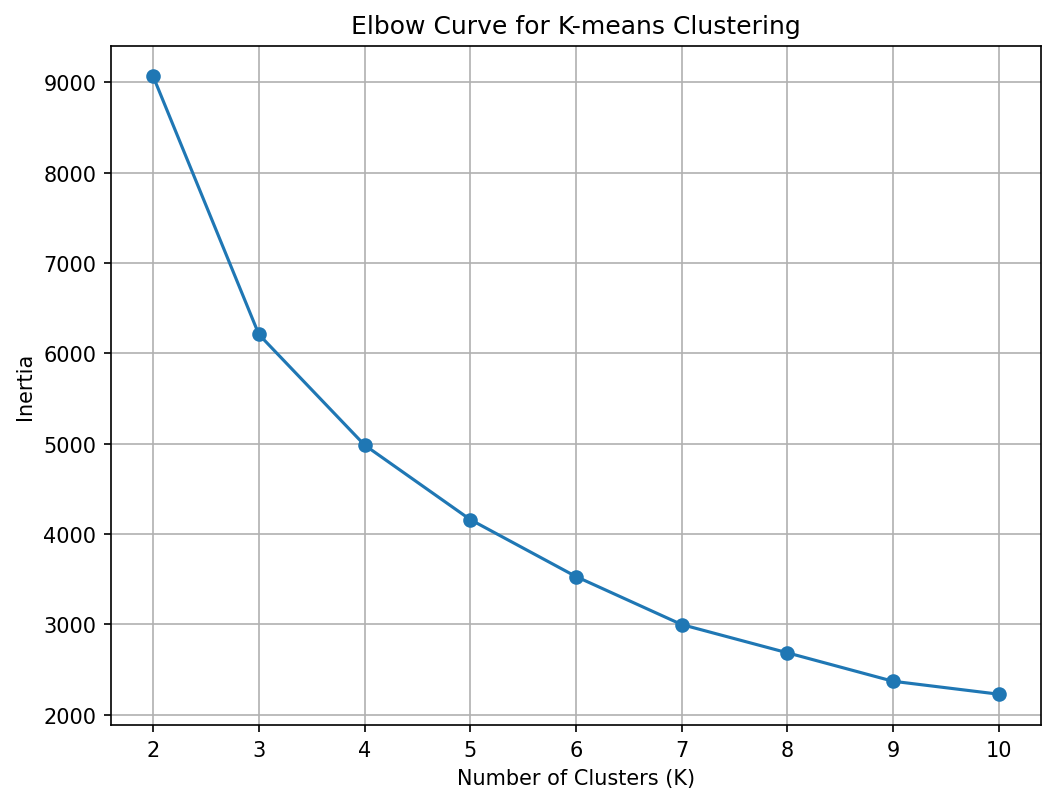

In [78]:
# Calculate inertia (sum of squared distances) for different values of k.
inertia = []
for k in range (2,11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    
# Plot the elbow curve
plt.figure(figsize=(8,6),dpi=150)
plt.plot(range(2,11), inertia, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.title('Elbow Curve for K-means Clustering')
plt.grid(True)
plt.show()

We see that the curve elbows out at 4 clusters. So we will divide the customer base into four segments.

In [79]:
# Perform K-means clustering with optimal K=4
best_kmeans = KMeans(n_clusters=4, n_init=10, random_state=42)
rfm['Cluster'] = best_kmeans.fit_predict(X)

In [82]:
# Group the customers by clusters and calcualate mean values
cluster_summary = rfm.groupby('Cluster').agg({
    'R_score': 'mean',
    'F_score': 'mean',
    'M_score': 'mean'
}).reset_index()

In [83]:
print(cluster_summary)

   Cluster   R_score   F_score   M_score
0        0  3.745358  1.090849  1.884615
1        1  3.245963  2.593789  3.237267
2        2  1.487368  1.055789  1.642105
3        3  4.813197  3.210967  3.868959


In [85]:
cluster_summary_value = rfm.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': 'mean',
})

In [86]:
print(cluster_summary_value)

            Recency  Frequency  MonetaryValue
Cluster                                      
0         54.340849   1.572944     459.620565
1         78.077019   4.465839    1903.361083
2        255.583158   1.332632     371.596505
3         12.857807  10.504647    5885.759981


#### Visualisation of the clusters

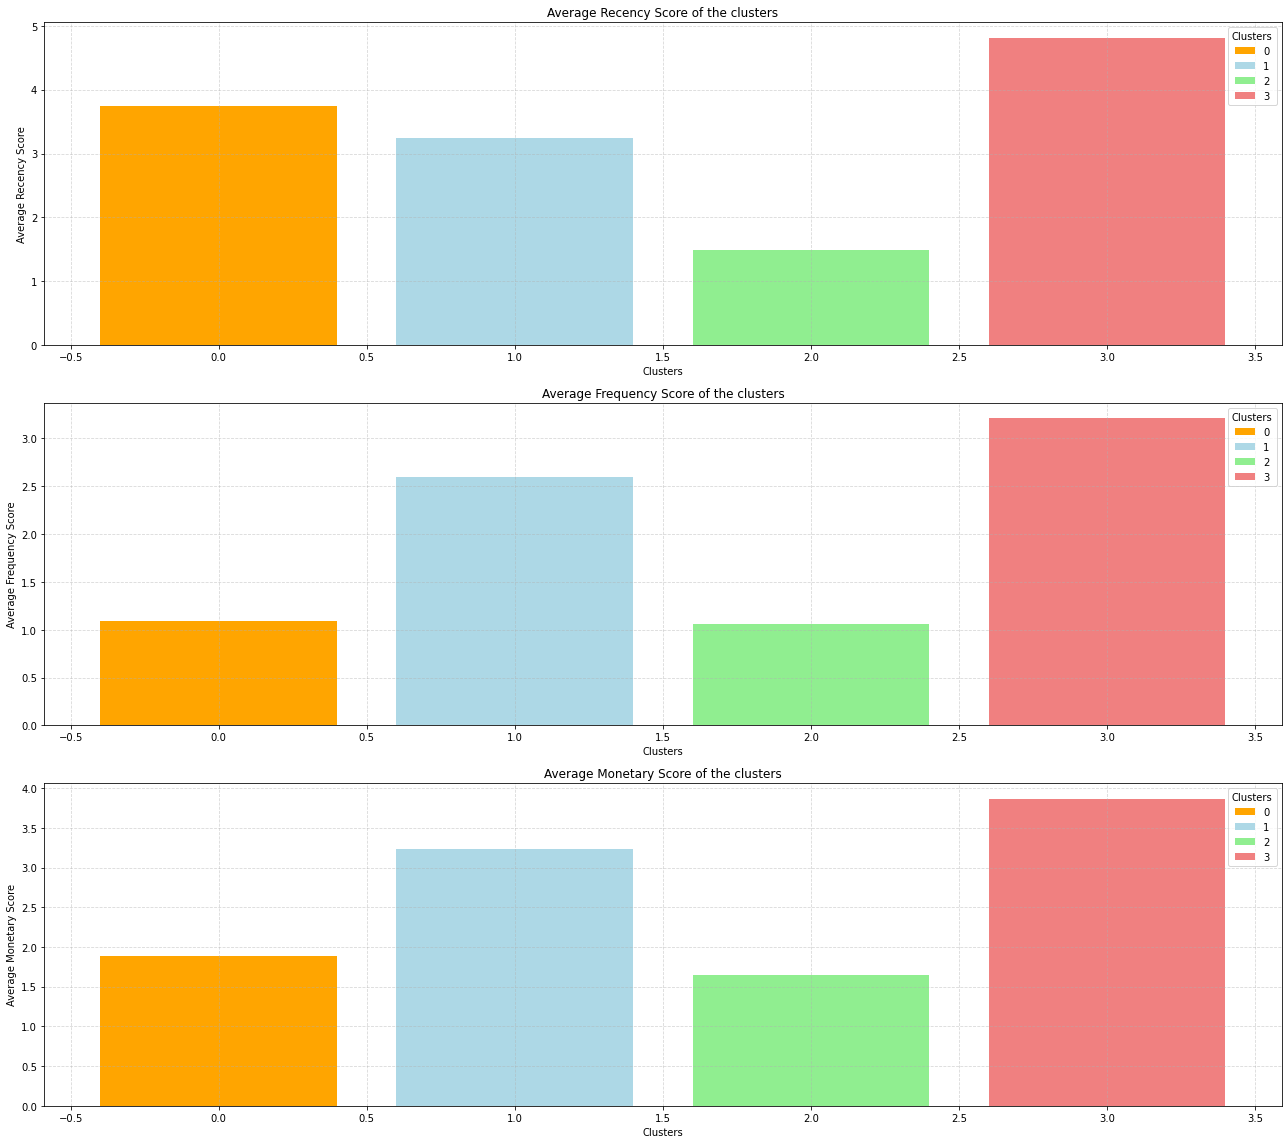

In [111]:
# set colours of each cluster
colours = ['orange', 'lightblue', 'lightgreen', 'lightcoral']

# Plot the average RFM scores for each cluster
plt.figure(figsize=(18,16))

# Plot Avg Recency Score
plt.subplot(3,1,1)
bars = plt.bar(cluster_summary.index, cluster_summary['R_score'], color = colours)
plt.xlabel('Clusters')
plt.ylabel('Average Recency Score')
plt.title('Average Recency Score of the clusters')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency Score
plt.subplot(3,1,2)
bars = plt.bar(cluster_summary.index, cluster_summary['F_score'], color = colours)
plt.xlabel('Clusters')
plt.ylabel('Average Frequency Score')
plt.title('Average Frequency Score of the clusters')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

# Plot Avg Frequency Score
plt.subplot(3,1,3)
bars = plt.bar(cluster_summary.index, cluster_summary['M_score'], color = colours)
plt.xlabel('Clusters')
plt.ylabel('Average Monetary Score')
plt.title('Average Monetary Score of the clusters')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bars, cluster_summary.index, title='Clusters')

plt.tight_layout()
plt.show()

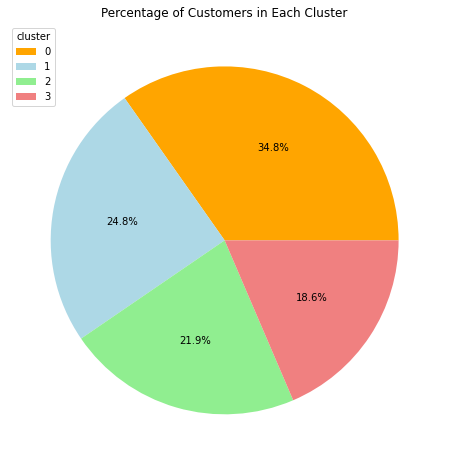

In [113]:
cluster_counts = rfm['Cluster'].value_counts()

colours = ['orange', 'lightblue', 'lightgreen', 'lightcoral']

# Calculate total number of customers
total_customers = cluster_counts.sum()

# Calculate the percentage of customers in each cluster
customers_percentage = (cluster_counts/total_customers) * 100

# Create a pie chart
plt.figure(figsize=(8,8))
plt.pie(customers_percentage, autopct = '%1.1f%%', colors = colours)
plt.title('Percentage of Customers in Each Cluster')
plt.legend(cluster_summary['Cluster'], title='cluster', loc='upper left')

plt.show()

### Interpretation of the clusters based on the characteristics
From the bar chart, we can tell that <br>
**- Cluster 0** has quite high Recency score, low Frequency score and average Monetary score. These customers are probably the **new or recent customers** who were just acquired.

**- Cluster 1** has relatively high Recency, Frequency and Monetary score. These are probably the **loyal customers** that the business want to retain.

**- Cluster 2** has lowest Recency, Frequency and Monetary score. They don't buy often, spend less and haven't made a recent purchase. These are likely the **at-risk customers** who will need more effort to gain them back.
<br>

**- Cluster 3** has highest Recency, Frequency and Monetary score. This type of customers usually called as the **Champions** customers in CRM.
<br>
<br>
From the pie chart, cluster 0 or the new customers made up more than 30% of the customer base. They are the new customers who have high potential to become loyal or champions customers if retain strategy done well. Cluster 1 is the second large group in the customer base. They are the loyal customers who consitently contribute sales to the business. Business must always pay attention to these customers in order to retain and grow this group. Besides that, there are 21.9% of customers (cluster 1) who are the at-risk customers. They might be the customers who have lost interest in the business or the customer who are on the fence after purchase once. Business should plan out the reactivation strategy in order to regain these customers. Lastly, there 18.6% of the customer base are made up by the Champions customers. They are the customer with highest purchase power. Business should always provide personalised services or offers to them or provide exclusive access or treatments to these customers to make them feel valued and appreciated.  

### Conclusion
This analytics helps business to understand their customer better and segment them based on their purchasing behaviour. The clustering methods helps to avoid some bias that could have been invovled if the segmentation is manually executed. Business can always perform this machine learning method on a regular basis (i.e. each quarter) to see if there's any movement of the clusters and evaluate if their strategy is done right.